# 问题提出
## 一般地，$N$​皇后问题描述如下：
### 在大小为$N \times N$的棋盘上摆放$N$个皇后，使其两两之间不能互相攻击，即任意两个皇后都不能处于棋盘的同一行、同一列或同一斜线上，求出满足条件的所有棋局及局面总数。
### 特殊地，当$N=8$​​时为著名的以国际象棋棋盘为背景的8皇后问题，易解得符合条件的局面总数为92。本实验主要探究$N \times N$​​的棋盘上摆放$N$​​​个皇后的一般问题，特别地，使用优化方法（全态形式化）而非搜索方法（增量形式化）。

# 导入包

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from queue import PriorityQueue
import time

plt.rcParams['font.sans-serif'] = ['SimHei']  # 正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [2]:
N = 8


# 存储方式：长度为N的一维数组，表示N个列/行的皇后位置
def random_state():
    return np.random.randint(0, N, N)

# 棋盘可视化

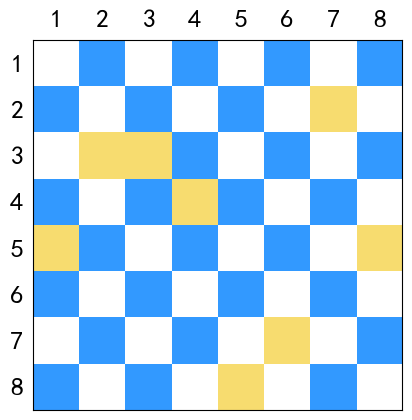

In [3]:
def plot_chess(result, col_mat=None, cur_col=None):
    '''
    # 棋盘可视化
    result:  皇后信息，长度为N的数组
    col_mat: 碰撞矩阵，不填写则不显示
    cur_col: 当前碰撞度（皇后冲突对数）
    '''
    color_yellow = (247 / 255, 220 / 255, 111 / 255)
    color_blue = (51 / 255, 153 / 255, 255 / 255)

    mat = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if result[j] == i:  # 皇后位置标黄
                mat[i, j] = 1
            elif (i + j) % 2 == 0:
                mat[i, j] = -1
            else:
                mat[i, j] = 0

    if col_mat is not None:
        plt.subplot(121)
    my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'my_camp', ['white', color_blue, color_yellow], 3)
    cs = plt.imshow(mat, cmap=my_cmap)

    labels = np.arange(1, N + 1)
    fontsize = 150 / N
    plt.xticks(np.arange(N), labels=labels, fontsize=fontsize)
    plt.yticks(np.arange(N), labels=labels, fontsize=fontsize)
    plt.tick_params(bottom=False, left=False, labeltop=True, labelbottom=False)

    if col_mat is not None:
        plt.subplot(122)
        plt.title('$h$: %d' % cur_col)
        sns.heatmap(col_mat, annot=True, cbar=False, square=True, cmap='YlGnBu',
                    xticklabels=labels, yticklabels=labels, mask=(col_mat==-1))

    plt.show()


N = 8
plot_chess(random_state())


# 计算皇后冲突数量（目标函数）

In [4]:
def collision(queens):
    '''目标函数：皇后冲突对数'''
    count = 0
    for j in range(N):
        i = queens[j]
        for l in range(1, N - j):
            if queens[j + l] in (i, i + l, i - l):
                count += 1
    return count

# 局部搜索方法

## 爬山法
### 在当前状态的所有后继中选择最好的解，直到无法达到更优

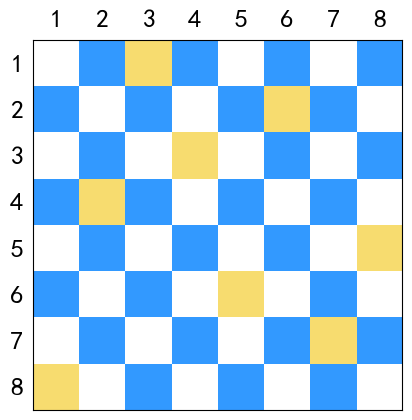

In [40]:
def hill_climbing(init_state, show_mat=False):
    '''
    # 爬山法
    init_state: 初始状态
    show_mat:   是否显示中间过程的碰撞矩阵
    '''
    state = init_state.copy()  # 用于迭代的状态
    min_h = min_i = min_j = None
    cur_h = collision(state)
    h = np.zeros((N, N))  # 碰撞矩阵
    step = 0
    
    while True:
        # N(N-1)个后继
        for j in range(N):
            row = state[j]
            for i in range(N):
                if i == row:
                    h[i, j] = -1  # 皇后所在位置不计算碰撞度（便于后续碰撞矩阵的显示）
                    continue
                state[j] = i
                h[i, j] = collision(state)
                state[j] = row  # 恢复
                if min_h is None or h[i, j] < min_h:  # 选出所有后继中最好的解
                    min_h, min_i, min_j = h[i, j], i, j
        
        if show_mat:
            plot_chess(state, h, cur_h)
        
        if min_h is not None and min_h < cur_h:  # 有更好的解
            state[min_j] = min_i
            cur_h = min_h
            step += 1
        else:
            break
    # end of while
    return state, cur_h, step
    
    
for i in range(10):
    ans, h, step = hill_climbing(random_state())
    # print(step)
    if h == 0:
        plot_chess(ans)

## 首选爬山法
### 随机地生成后继节点直到生成一个优于当前节点的后继，这个算法在后继节点很多的时候是个好策略。

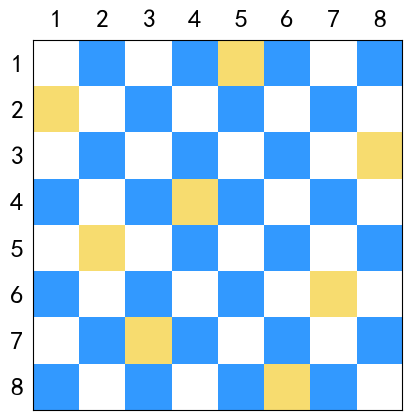

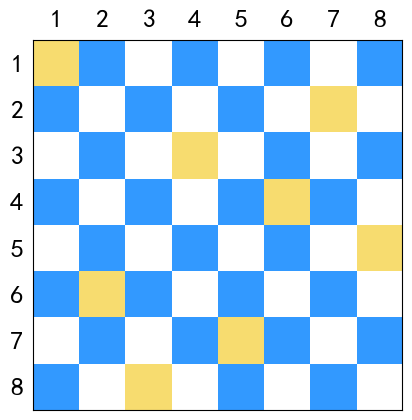

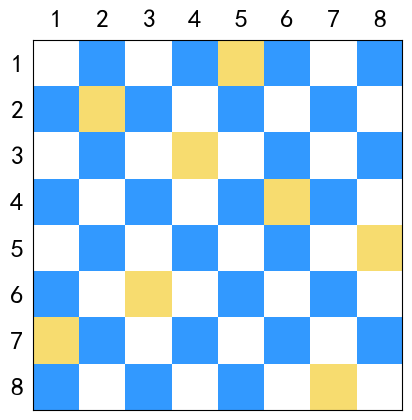

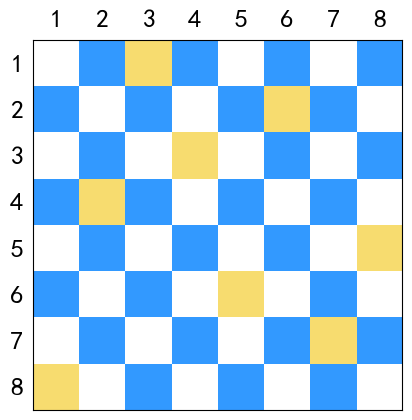

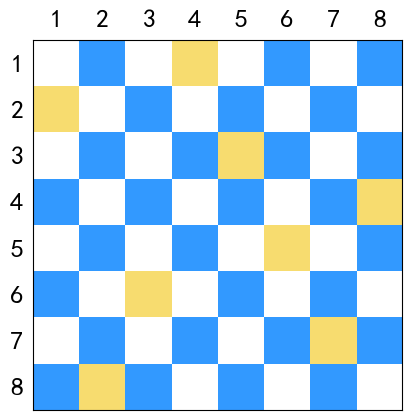

In [41]:
def shuffle(arr=np.array([])):  # 便于后续随机取一个后继节点而不产生重复
    '''洗牌算法'''
    n = len(arr)
    for i in range(n):
        rand = np.random.randint(i, n)
        arr[i], arr[rand] = arr[rand], arr[i]
    return arr


def first_choice(init_state):
    '''
    # 首选爬山法
    init_state: 初始状态
    '''
    state = init_state.copy()  # 用于迭代的状态
    min_i = min_j = None
    min_h = cur_h = collision(state)
    step = 0

    while True:
        # N(N-1)个后继
        rands = shuffle(np.arange(N ** 2))  # 后继下标集合（洗牌算法打乱）
        for rand in rands:
            # 随机取一个后继
            i = rand // N
            j = rand % N
            row = state[j]
            if i == row:
                continue
            state[j] = i
            h = collision(state)
            state[j] = row  # 恢复
            if h < min_h:  # 直到生成一个比当前状态好的后继
                min_h, min_i, min_j = h, i, j
                break
        
        if min_h < cur_h:  # 有更好的解
            state[min_j] = min_i
            cur_h = min_h
            step += 1
        else:
            break
    # end of while
    return state, cur_h, step


for i in range(10):
    ans, h, step = first_choice(random_state())
    # print(step)
    if h == 0:
        plot_chess(ans)


## 随机重启爬山法
### 随机生成初始状态来导引爬山法搜索，直到找到目标。

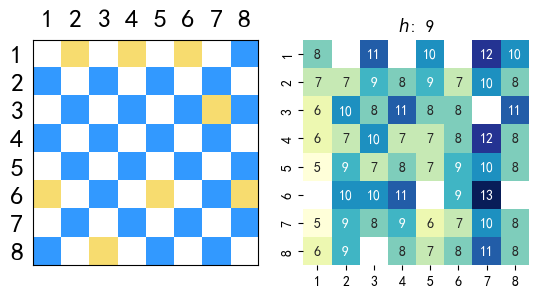

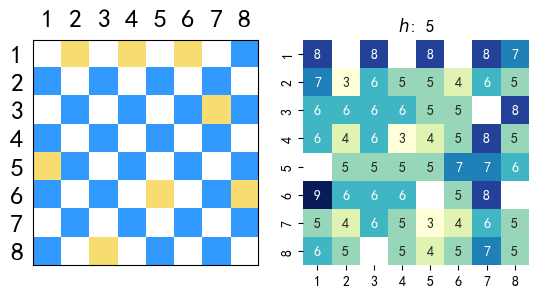

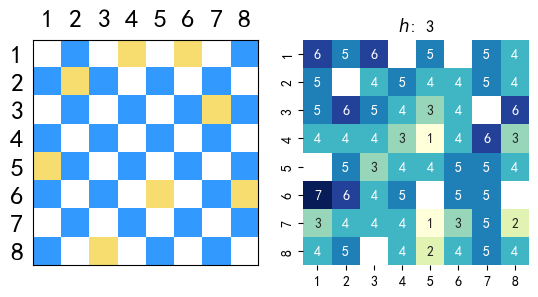

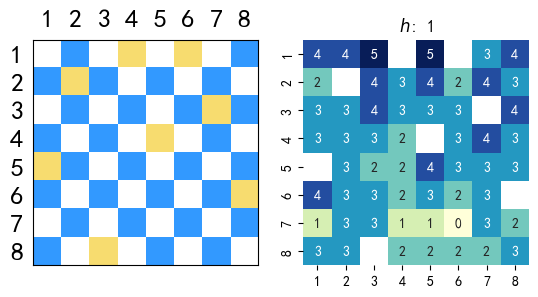

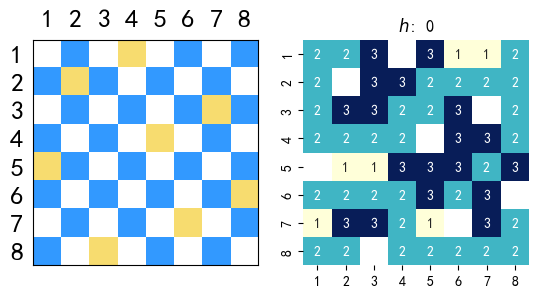

0
4


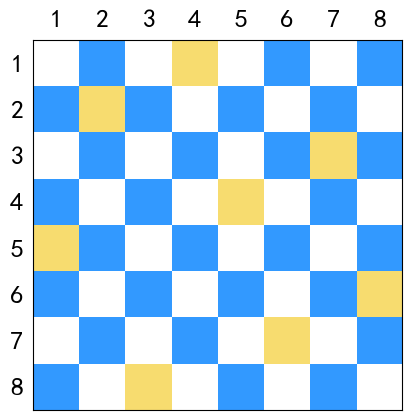

In [48]:
def random_restart(init_state, limit=-1, show_mat=False):
    '''
    # 随机重启爬山法
    init_state: 初始状态
    limit:      随机重启次数上限，负数表示没有上限
    show_mat:   是否显示中间过程的碰撞矩阵
    '''
    ans, h, step = hill_climbing(init_state, show_mat)
    while h > 0 and limit != 0:
        ans, h, step0 = hill_climbing(random_state(), show_mat)
        limit -= 1
        step += step0 + 1  # 重启也算一步
    return ans, h, step


N = 8
ans, h, step = random_restart(random_state(), limit=10, show_mat=True)
print(collision(ans))
print(step)
plot_chess(ans)

## 局部束搜索

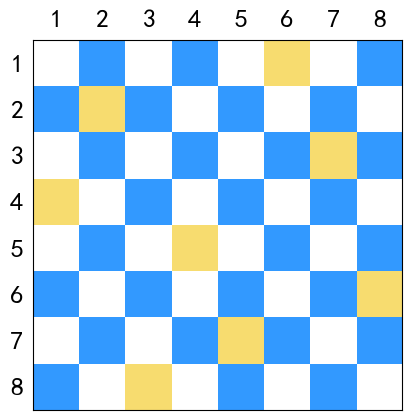

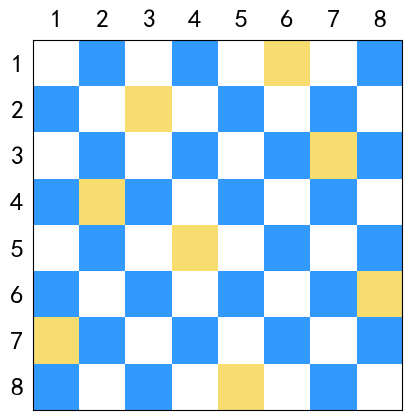

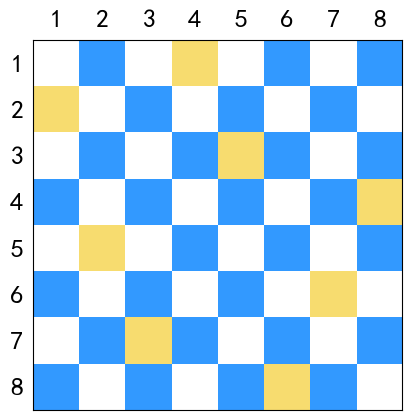

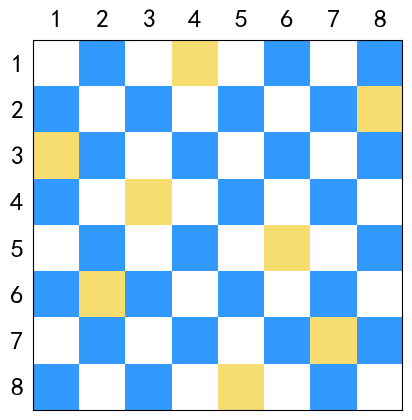

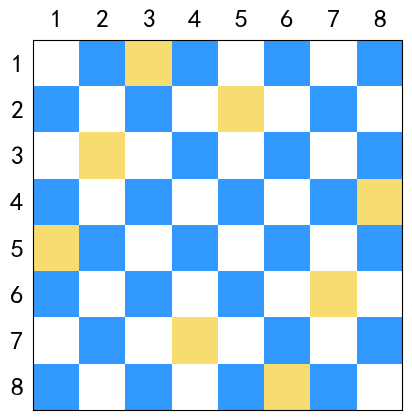

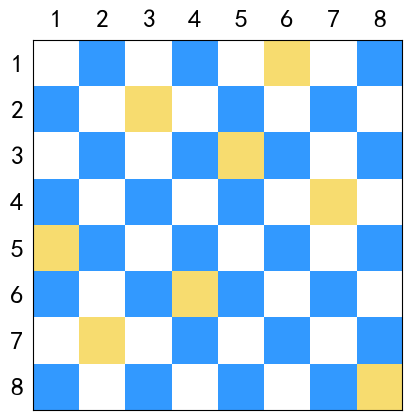

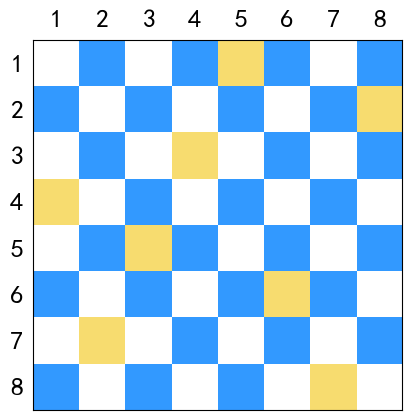

7


In [32]:
def local_beam(k=5):
    '''
    # 局部束搜索
    k: 集束宽度
    '''
    states = np.random.randint(0, N, (k, N))
    cur_h = np.array([collision(state) for state in states])
    min_idx = np.argmin(cur_h)
    min_h = cur_h[min_idx]
    min_state = states[min_idx]
    que = PriorityQueue()  # [h, state]
    step = 0

    while True:
        que.queue.clear()  # 每次循环直接清空
        # print(cur_h)
        for state in states:
            # N(N-1)个后继
            for j in range(N):
                row = state[j]
                for i in range(N):
                    if i == row:
                        continue
                    state[j] = i
                    # 这里把ndarray转成list是因为PriorityQueue似乎不完全支持ndarray，
                    # 优先级重复直接报错，故先转成list，取出再转回ndarray
                    que.put([collision(state), list(state)])
                    state[j] = row  # 恢复

        for l in range(k):  # 选出所有后继中k个最好的
            cur_h[l], states_list = que.get()
            states[l] = np.array(states_list)
        if cur_h[0] == 0 or cur_h[0] >= min_h:
            break

        min_h, min_state = cur_h[0], states[0]
        step += 1
    # end of while
    return states[0], cur_h[0], step


count = 0
for i in range(10):
    ans, h, step = local_beam(k=20)
    # print(step)
    if h == 0:
        plot_chess(ans)
        count += 1
print(count)


# 元启发式方法

## 模拟退火算法

In [24]:
def simulated_annealing(init_state, r=0.99):
    '''
    # 模拟退火算法
    init_state: 初始状态
    r:          退火速率
    '''
    state = init_state.copy()  # 用于迭代的状态
    temp = 5.0  # 温度T
    cur_h = collision(state)
    step = 0
    
    while temp > 1e-5 and cur_h > 0:  # 注意循环结束的条件
        while True:
            # N(N-1)个后继中随机取一个
            rand = np.random.randint(0, N ** 2)
            i = rand // N
            j = rand % N
            row = state[j]
            if i != row:
                break
        
        state[j] = i
        next_h = collision(state)
        state[j] = row  # 恢复
        
        # 注意这里是求min，delta_E要反过来取
        accepted = False
        delta_E = next_h - cur_h
        if delta_E < 0:  # 接受
            accepted = True
        elif np.random.random() < np.exp(-delta_E / temp):  # 以概率p接受
            accepted = True
            
        if accepted:
            cur_h = next_h
            state[j] = i
        
        # 冷却
        temp *= r
        step += 1
    # end of while
    return state, cur_h, step


count = 0
N = 8
for i in range(1):
    ans, h, step = simulated_annealing(random_state(), r=0.99)
    if h == 0:
        # plot_chess(ans)
        count += 1
print(step)
print(count)

272
1


## 遗传算法

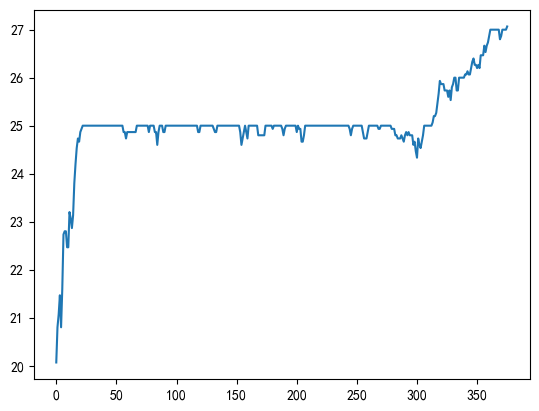

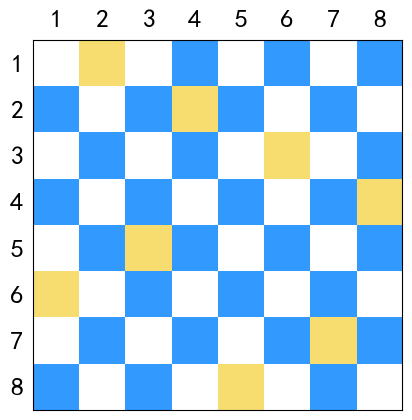

375
0


In [44]:
def genetic(size=5, max=10000, pc=0.5, pm=0.01, plot=False):
    '''
    # 遗传算法
    size: 种群中的个体数量
    max:  最大繁衍次数
    pc:   交叉率
    pm:   变异率
    plot: 是否绘制适应度进化过程
    '''
    def init():
        return np.random.randint(0, N, (size, N))

    def fitness(individual):
        '''标准适应度函数'''
        return N * (N - 1) / 2 - collision(individual)

    def selection(population, f):
        '''选择：轮盘赌模式'''
        p = f / np.sum(f)  # 选入配对池的概率
        return population[np.random.choice(np.arange(size), size=size, replace=True, p=p)]

    def crossover(population, pc=0.5):
        '''（单点）交叉'''
        # 按顺序两两配对交叉，这是因为选择环节保证了随机性
        for i in range(0, int(size * pc) - 1, 2):  #减1防止超范围
            rand = np.random.randint(0, N)
            for j in range(rand, N):
                population[i][j], population[i + 1][j] = \
                population[i + 1][j], population[i][j]
        return population

    def mutation(population, pm=0.01):
        '''变异'''
        for individual in population:
            if np.random.random() < pm:
                position, value = np.random.randint(0, N, 2)
                individual[position] = value
        return population
    
    pop = init()  # 初始种群
    gfit = np.zeros(max)  # 每一代的适应度均值
    for generation in range(max):
        fit = np.array([fitness(i) for i in pop])  # 计算适应度
        if plot:
            gfit[generation] = np.mean(fit)
        max_idx = np.argmax(fit)
        best = pop[max_idx]  # 最优个体
        if fit[max_idx] == N * (N - 1) / 2:
            break
        # 选择，交叉，变异
        pool = selection(pop, fit)
        pool = crossover(pool, pc)
        pop  = mutation (pool, pm)
        pop[size - 1] = best  # 保留最优个体
    
    if plot:
        plt.plot(np.arange(generation + 1), gfit[:generation + 1])
        plt.show()
    idx = np.argmax(fit)
    return pop[idx], int(N * (N - 1) / 2 - fit[idx]), generation


N = 8
ans, h, generation = genetic(size=15, max=10000, pc=0.75, pm=0.0075, plot=True)
if h == 0:
    plot_chess(ans)
print(generation)
print(h)

# 统计

In [33]:
columns = '算法', '参数', '成功次数', '失败次数', '成功率', '成功平均步数', '失败平均步数', '总耗时'
df = pd.DataFrame(columns=columns)

times = 1000
init_states = np.random.randint(0, N, (times, N))


def evaluate(func, algorithm, param, *arg):
    series = {}
    success = 0
    step = np.zeros(times)
    h = np.zeros(times)
    
    begin_time = time.time()
    for i in range(times):
        if func in (local_beam, genetic):
            ans, h[i], step[i] = func(*arg)
        else:
            ans, h[i], step[i] = func(init_states[i], *arg)
        if h[i] == 0:
            success += 1
    end_time = time.time()
    
    series['算法'] = algorithm
    series['参数'] = param
    series['成功次数'] = success
    series['失败次数'] = times - success
    series['成功率'] = '{:.2%}'.format(success / times)
    series['成功平均步数'] = round(np.mean(step[h == 0]), 2)
    series['失败平均步数'] = round(np.mean(step[h > 0]), 2)
    series['总耗时'] = round(end_time - begin_time, 2)
    df.loc[len(df)] = series
    

evaluate(hill_climbing, '爬山法', '')
evaluate(first_choice, '首选爬山法', '')
evaluate(random_restart, '随机重启爬山法', 'lim=5', 5)
evaluate(random_restart, '随机重启爬山法', 'lim=10', 10)
evaluate(random_restart, '随机重启爬山法', 'lim=20', 20)
evaluate(random_restart, '随机重启爬山法', 'lim=50', 50)
evaluate(local_beam, '局部束搜索', 'k=5', 5)
evaluate(local_beam, '局部束搜索', 'k=10', 10)
evaluate(local_beam, '局部束搜索', 'k=20', 20)
evaluate(local_beam, '局部束搜索', 'k=50', 50)
evaluate(simulated_annealing, '模拟退火算法', 'r=0.99', 0.99)
evaluate(simulated_annealing, '模拟退火算法', 'r=0.999', 0.999)
evaluate(simulated_annealing, '模拟退火算法', 'r=0.9999', 0.9999)
# about 5min30s
evaluate(genetic, '遗传算法', 'T=1000', 15, 1000, 0.75, 0.0075)
evaluate(genetic, '遗传算法', 'T=5000', 15, 5000, 0.75, 0.0075)
# about 28min
df.to_excel('optimization.xlsx')
df

d:\Program Files\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Program Files\Python\Python39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Program Files\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Program Files\Python\Python39\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,算法,参数,成功次数,失败次数,成功率,成功平均步数,失败平均步数,总耗时
0,爬山法,,169,831,16.90%,4.09,3.10,2.20
1,首选爬山法,,153,847,15.30%,6.24,4.75,1.88
2,随机重启爬山法,lim=5,611,389,61.10%,11.95,23.43,9.02
3,随机重启爬山法,lim=10,837,163,83.70%,17.80,43.66,11.93
4,随机重启爬山法,lim=20,974,26,97.40%,24.34,82.88,14.56
5,随机重启爬山法,lim=50,1000,0,100.00%,28.28,NaN,15.30
6,局部束搜索,k=5,364,636,36.40%,2.22,2.30,11.12
7,局部束搜索,k=10,478,522,47.80%,2.06,1.97,21.54
8,局部束搜索,k=20,636,364,63.60%,1.81,1.62,38.30
9,局部束搜索,k=50,765,235,76.50%,1.52,1.08,87.47
